In [1]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import scipy.signal as sps
import astropy.timeseries as ts
from astropy.io import fits
import os, sys, time
from spinneret import *

In [2]:
rotators = pd.read_csv('S21_train.csv')
# control = pd.read_csv('M14nonrotators.csv')

kic_r = rotators['KIC']
p_r = rotators['Prot']
# kic_c = control['KIC']

kep_cadence = 1/24/2 # 30min cadence
tess_cadence = 1/24/30 # 2min cadence, for use later

# butterworth filter for tessify data
sos = sps.butter(3, (1/27), 'hp', fs=48, output='sos')

In [3]:
k = 1027016 #1026146 # 1576970 tol val #1570150
i = kic_r.index[kic_r==k][0]

# start = time.time()
if len(str(k)) == 6:
    openstr = '000' + str(k)
elif len(str(k)) == 7:
    openstr = '00' + str(k)
else:
    openstr = '0' + str(k)

In [4]:
hdu = fits.open(f'kplr{openstr}-2011177032512_llc.fits') # Q9, will need changing for TESS data
table = hdu[1].data
time = table['TIME']
flux = table['PDCSAP_FLUX']
time, flux = nancleaner2d(time, flux)
time, flux = clip(time, flux, 3) #3 sigma clip
flux = lk.LightCurve(time=time, flux=flux).normalize().flux.value - 1

## Kepler

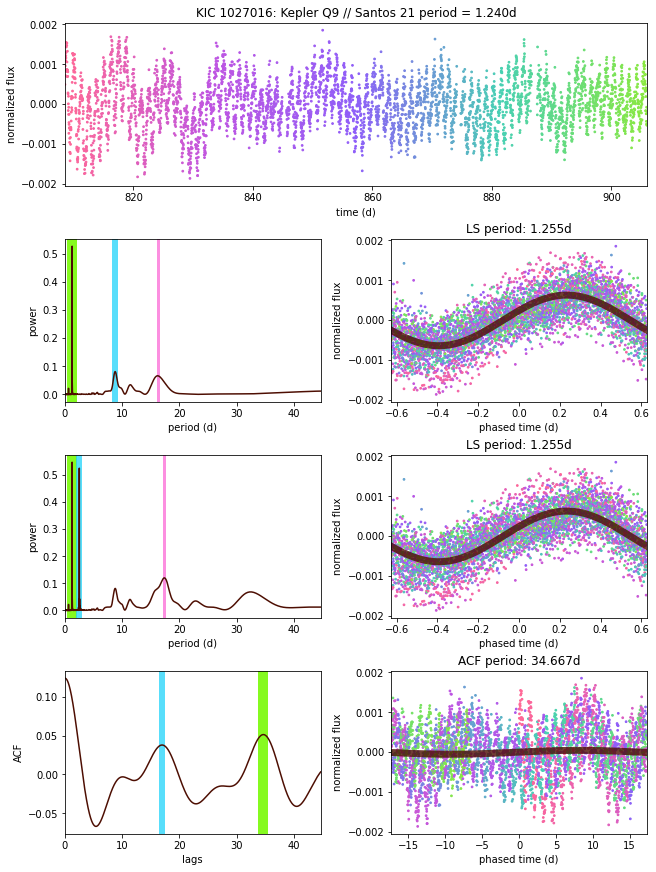

In [5]:
target_kep = Spinner(time, flux)

freq, ps = ts.LombScargle(time, flux).autopower(nyquist_factor=1, samples_per_peak=30)
target_kep.ls_one_term(freq, ps)

freq, ps = ts.LombScargle(time, flux, nterms=2).autopower(nyquist_factor=1, samples_per_peak=30)
target_kep.ls_two_term(freq, ps)

lags_raw, acf_raw, lags, acf, _x, _y = simple_acf(time, flux, kep_cadence, width=16)
target_kep.acf(lags, acf)

fig1 = target_kep.diagnostic_plot(heading=f'KIC {k}: Kepler Q9 // Santos 21 period = {p_r[i]:.3f}d')

In [6]:
target_kep.rms_ls1a, target_kep.rms_ls2a, target_kep.rms_acfa

(9.674912972859209e-05, 9.674912972859209e-05, 0.0002820826600463816)

## TESSify

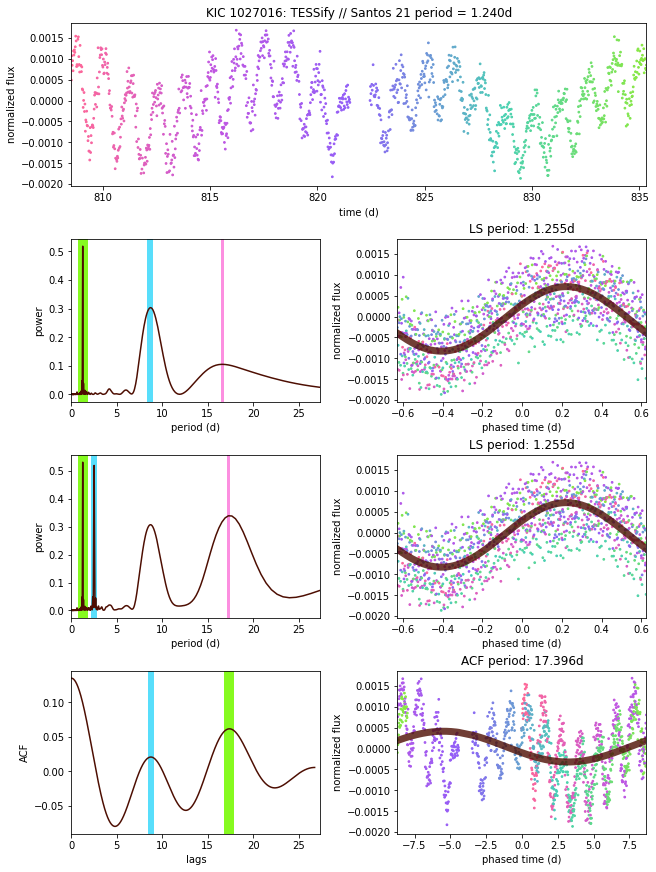

In [7]:
time_tess, flux_tess = tessify(time, flux)

target_tess = Spinner(time_tess, flux_tess)

freq, ps = ts.LombScargle(time_tess, flux_tess).autopower(nyquist_factor=1, samples_per_peak=30)
target_tess.ls_one_term(freq, ps)

freq, ps = ts.LombScargle(time_tess, flux_tess, nterms=2).autopower(nyquist_factor=1, samples_per_peak=30)
target_tess.ls_two_term(freq, ps)

lags_raw, acf_raw, lags, acf, _x, _y = simple_acf(time_tess, flux_tess, kep_cadence, width=16)
target_tess.acf(lags, acf)

fig2 = target_tess.diagnostic_plot(heading=f'KIC {k}: TESSify // Santos 21 period = {p_r[i]:.3f}d')

In [8]:
target_tess.rms_ls1a, target_tess.rms_ls2a, target_tess.rms_acfa

(0.00011442237259456701, 0.00011442237259456701, 0.0006349484799852443)

## filtered TESSify

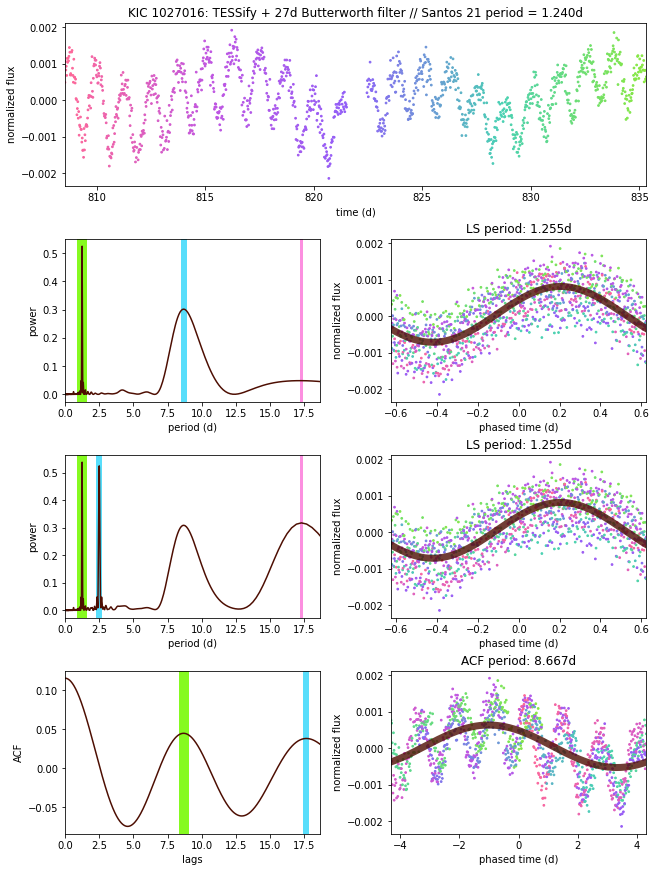

In [9]:
time_butter, flux_butter = tessify(time, sps.sosfilt(sos, flux))

target_butter = Spinner(time_butter, flux_butter)

freq, ps = ts.LombScargle(time_butter, flux_butter).autopower(nyquist_factor=1, samples_per_peak=30)
target_butter.ls_one_term(freq, ps)

freq, ps = ts.LombScargle(time_butter, flux_butter, nterms=2).autopower(nyquist_factor=1, samples_per_peak=30)
target_butter.ls_two_term(freq, ps)

lags_raw, acf_raw, lags, acf, _x, _y = simple_acf(time_butter, flux_butter, kep_cadence, width=16)
target_butter.acf(lags, acf)

fig3 = target_butter.diagnostic_plot(heading=f'KIC {k}: TESSify + 27d Butterworth filter // Santos 21 period = {p_r[i]:.3f}d')

In [10]:
target_butter.rms_ls1a, target_butter.rms_ls2a, target_butter.rms_acfa

(0.00011555845242759831, 0.00011555845242759831, 0.0004914513229291114)